# Libraries

In [1]:
import os
import time
import torch
import torchaudio
import subprocess
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, Subset
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from pytorch_metric_learning import miners, losses, distances
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from torch_audiomentations import AddBackgroundNoise, AddColoredNoise, Gain, PitchShift

# Constants

In [ ]:
CACHE_DIR = "./cache"
SONGS_DIR = f"{CACHE_DIR}/songs"
SEGMENTS_DIR = f"{CACHE_DIR}/segments"  
SPECTOGRAMS_DIR = f"{CACHE_DIR}/spectograms"

ASSETS_DIR = "./assets"
BACKGROUND_NOISE_DIR = f"{ASSETS_DIR}/background_noises"

DATASET_FILE = f"{CACHE_DIR}/dataset.csv"
EMBEDDINGS_FILE = f"{CACHE_DIR}/embeddings.npz" 
TRAINED_MODEL_FILE = f"{CACHE_DIR}/trained_model.pt"

SPOTIFY_PLAYLIST_URL="https://open.spotify.com/playlist/1Y0Qk1K1DEMXeKgvjjnN7m?si=80a2a297dded480b"
# SPOTIFY_PLAYLIST_URL="https://open.spotify.com/playlist/34NbomaTu7YuOYnky8nLXL?si=4bf54104cf4c480c"

TARGET_SAMPLE_RATE = 16000
SEGMENT_DURATION = 3 # seconds

# CNN model parameters  
BATCH_SIZE = 32
NUM_WORKERS = 0
SHUFFLE = True

NUM_TESTS = 100

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create needed directories
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(SONGS_DIR, exist_ok=True)
os.makedirs(SPECTOGRAMS_DIR, exist_ok=True)
os.makedirs(SEGMENTS_DIR, exist_ok=True)
os.makedirs(ASSETS_DIR, exist_ok=True)  
os.makedirs(BACKGROUND_NOISE_DIR, exist_ok=True)  

In [3]:
if (len(os.listdir(BACKGROUND_NOISE_DIR)) == 0):
  raise Exception(f"Please download background noise files to {BACKGROUND_NOISE_DIR} directory.")

# Download Songs

In [4]:
if len(os.listdir(SONGS_DIR)) == 0:
  print(f"Songs directory is empty, downloading songs from {SPOTIFY_PLAYLIST_URL}")

  # Download songs
  subprocess.run(
    ["spotdl", SPOTIFY_PLAYLIST_URL],
    check=True,
    cwd=SONGS_DIR,
  )
else:
  print(f"The songs directory is not empty, skipping download.")

# Check if the songs dir already has the names changed
if not (all(isinstance(song.split(".")[0], int) for song in os.listdir(SONGS_DIR))): 
  print(f"Renaming songs in {SONGS_DIR} to integers")
  for i, song in enumerate(tqdm(os.listdir(SONGS_DIR), desc="Renaming songs", unit="song")):
    song_path = os.path.join(SONGS_DIR, song)
    song_extension = song.split(".")[-1]

    file_path = os.path.join(SONGS_DIR, f"{i}.{song_extension}")

    os.rename(
      song_path,
      file_path,
    )
else: 
  print(f"The songs directory already has the names changed, skipping renaming.")

Songs directory is empty, downloading songs from https://open.spotify.com/playlist/1Y0Qk1K1DEMXeKgvjjnN7m?si=80a2a297dded480b
Renaming songs in ./cache/songs to integers


Renaming songs: 100%|██████████| 10/10 [00:00<00:00, 3461.22song/s]


# Extract features

In [5]:
mel_spec_transform = torch.nn.Sequential(
    MelSpectrogram(n_fft=2048, hop_length=512, n_mels=128, f_min=20, f_max=8000),
    AmplitudeToDB(),
  )
# Compile the model
mel_spec_transform = torch.jit.script(mel_spec_transform.to(device))

def get_spectogram(waveform, as_numpy=True):
  with torch.no_grad(): 
    mel_spec = mel_spec_transform(waveform)
  mel_spec = mel_spec.to(device)  # Move to GPU if available  

  if as_numpy:
    return mel_spec.cpu().detach().numpy()

  return mel_spec 

def get_waveform_n_sr_from_file(file_path):
  waveform, sr = torchaudio.load(file_path, normalize=True)

  if sr != TARGET_SAMPLE_RATE:  
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)
    waveform = resampler(waveform)

  waveform = waveform.mean(dim=0, keepdim=True)  # Convert to mono
  waveform = waveform.unsqueeze(0)  
  waveform = waveform.to(device)  # Move to GPU if available

  return waveform, TARGET_SAMPLE_RATE

def get_global_mean_std(files):
  sum_        = 0.0
  sum_sq      = 0.0
  count       = 0

  for file in files:
    file_path = os.path.join(SONGS_DIR, file) 
    waveform, sr = get_waveform_n_sr_from_file(file_path) 
    spec_np = get_spectogram(waveform, as_numpy=False)

    vals = spec_np.flatten()

    sum_ += vals.sum()
    sum_sq += (vals ** 2).sum()
    count += vals.numel()

  mean_global = sum_ / count
  var_global  = sum_sq / count - mean_global**2
  std_global  = torch.sqrt(var_global)

  return mean_global.cpu().detach().numpy(), std_global.cpu().detach().numpy()

def save_spectogram(segment, song_id, chunk_id, aug_name, variation=0):
    file_name = f"{song_id}_{chunk_id}_{aug_name}_{variation}.npz"

    # Store as compressed file
    np.savez_compressed(
      os.path.join(SPECTOGRAMS_DIR, file_name),
      data=segment
    )

    return {
      "song_id": song_id,
      "file_name": file_name,
      "chunk_id": chunk_id,
      "aug_name": aug_name,
      "variation": variation,
    }

global_mean, global_std = get_global_mean_std(os.listdir(SONGS_DIR))

def extract_features():
  records = []

  for song in tqdm(os.listdir(SONGS_DIR), desc="Extracting features of the songs", unit="song"):
    song_path = os.path.join(SONGS_DIR, song)
    song_id = os.path.splitext(song)[0]

    waveform, sr = get_waveform_n_sr_from_file(song_path)

    segments_samples = int(SEGMENT_DURATION * sr)
    total_samples = waveform.shape[2]

    hop_length = segments_samples // 2
    chunk_id = 0
    for start in range(0, total_samples - segments_samples + 1, hop_length):

      if start + segments_samples > total_samples:
        break

      end = start + segments_samples
      segment = waveform[:, :, start:end]

      with torch.no_grad():
        mel_spec = get_spectogram(segment)

      # Normalize using the global mean & st
      mel_spec = (mel_spec - global_mean) / global_std

      segment_file = f"{song_id}_{chunk_id}.wav"

      # Save the segment
      torchaudio.save(
        os.path.join(SEGMENTS_DIR, segment_file),
        segment.cpu().squeeze(0),
        sr,
      )

      records.append(
        save_spectogram(mel_spec, song_id, chunk_id, "original")
      )

      chunk_id += 1
    
  # Save the dataframe
  df = pd.DataFrame(records)
  df.to_csv(DATASET_FILE, index=False)

if (len(os.listdir(SPECTOGRAMS_DIR)) == 0 or len(os.listdir(SEGMENTS_DIR)) == 0):
  print("Not founded spectograms, extracting them...")
  extract_features()
else:
  print("Founded spectograms, skiping it")

Not founded spectograms, extracting them...


Extracting features of the songs: 100%|██████████| 10/10 [00:13<00:00,  1.34s/song]


# Balance classes using augmentations

In [6]:
augmentations = {
    "background_noise": AddBackgroundNoise(
      p=0.5,
      background_paths=BACKGROUND_NOISE_DIR,
      min_snr_in_db=10,
      max_snr_in_db=20,
      output_type="dict"
    ),  
    "colored_noise": AddColoredNoise(
      p=0.5,
      min_snr_in_db=10,
      max_snr_in_db=20,
      output_type="dict"
    ),
    "gain": Gain(
      p=0.5,  
      min_gain_in_db=-10,
      max_gain_in_db=20,
      output_type="dict"
    ),
    "pitch_shift": PitchShift(
      p=0.5,
      min_transpose_semitones=-2,
      max_transpose_semitones=2,
      sample_rate=TARGET_SAMPLE_RATE,
      output_type="dict"
    ),
  }

def augment_data():
  df = pd.read_csv(DATASET_FILE)

  if (df["aug_name"] == "original").all():
    print("The dataset only has original data, applying augmentation.")

    # Get the number of clases per song_id
    print(df["song_id"].value_counts())

    number_of_samples_target = df["song_id"].value_counts().max() * 1.5

    print(f"Target number of samples: {number_of_samples_target}")

    unique_song_ids = df["song_id"].unique()
    
    for song_id in tqdm(unique_song_ids, desc="Augmenting data", unit="song"):
      song_df = df[df["song_id"] == song_id]

      while df[df["song_id"] == song_id].shape[0] < number_of_samples_target:
        # Get a random sample of the original data
        sample = song_df.sample(n=1, random_state=np.random.randint(0, 10000)).iloc[0]
        segment_file = f"{song_id}_{sample['chunk_id']}.wav"
        file_path = os.path.join(SEGMENTS_DIR, segment_file)

        # Apply a random augmentation
        aug_name = np.random.choice(list(augmentations.keys()))
        augment = augmentations[aug_name]

        waveform, sr = get_waveform_n_sr_from_file(file_path)
        mel_spec = get_spectogram(waveform)
        augmented_segment = augment(waveform, sample_rate=TARGET_SAMPLE_RATE)['samples']
        mel_spec = get_spectogram(augmented_segment)
        mel_spec = (mel_spec - global_mean) / global_std  

        # Check if its a variation
        duplicated = df[
          (df["song_id"] == song_id) & 
          (df["chunk_id"] == sample["chunk_id"]) &
          (df["aug_name"] == aug_name)
        ]

        if duplicated.shape[0] > 0:
          variation_num = duplicated["variation"].max() + 1
        else:
          variation_num = 0
        

        record = save_spectogram(
          mel_spec,
          song_id,
          sample["chunk_id"],
          aug_name,
          variation=variation_num 
        )

        # Append the record to the dataframe
        df = pd.concat([df, pd.DataFrame([record])], ignore_index=True)

    df.to_csv(DATASET_FILE, index=False)
    print(df["song_id"].value_counts())

  else:
    print("The dataset already has augmented data, skipping augmentation.")
    return
  
augment_data()

The dataset only has original data, applying augmentation.
song_id
6    207
0    188
2    169
5    160
9    152
3    147
7    134
8    119
1    104
4     94
Name: count, dtype: int64
Target number of samples: 310.5


Augmenting data: 100%|██████████| 10/10 [00:27<00:00,  2.71s/song]

song_id
0    311
1    311
2    311
3    311
4    311
5    311
6    311
7    311
8    311
9    311
Name: count, dtype: int64


# Dataloaders

In [7]:
class SpectogramDataset(Dataset):
  def __init__(self, spectograms_dir=SPECTOGRAMS_DIR, transform=None):
    self.spectograms_files = os.listdir(SPECTOGRAMS_DIR)
    self.spectograms_dir = spectograms_dir
    self.transform = transform

  def __len__(self):
    return len(self.spectograms_files)
  
  def __getitem__(self, idx):
    file_name = self.spectograms_files[idx]
    file_path = os.path.join(self.spectograms_dir, file_name)

    mel_spec = np.load(file_path)["data"] 

    if mel_spec.ndim == 4:
      mel_spec = mel_spec.squeeze(0).squeeze(0)
    elif mel_spec.ndim == 3:
      mel_spec = mel_spec.squeeze(0) 
        
    mel_spec = mel_spec[np.newaxis, ...]

    label = int(file_name.split("_")[0])  # Get the song id from the file name 

    if self.transform:
      mel_spec = self.transform(mel_spec) 

    mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.int64)

    return mel_spec, label

def get_spectograms():
  dataset = SpectogramDataset()

  idx = list(range(len(dataset)))
  train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

  train_subset = Subset(dataset, train_idx)   
  test_subset  = Subset(dataset, test_idx)

  return train_subset, test_subset

# Using a CNN te extract embeddings

Model not trained. Training model with cuda...
Epoch 0/50 - Train Loss: 0.4898 - Val Loss: 0.5226 - ETA: 2199.96s
Epoch 1/50 - Train Loss: 0.4640 - Val Loss: 0.4423 - ETA: 1177.42s
Epoch 2/50 - Train Loss: 0.4393 - Val Loss: 0.3939 - ETA: 829.91s
Epoch 3/50 - Train Loss: 0.4061 - Val Loss: 0.4031 - ETA: 654.31s
Epoch 4/50 - Train Loss: 0.3409 - Val Loss: 0.3697 - ETA: 547.44s
Epoch 5/50 - Train Loss: 0.3115 - Val Loss: 0.2838 - ETA: 474.76s
Epoch 6/50 - Train Loss: 0.2707 - Val Loss: 0.3103 - ETA: 421.84s
Epoch 7/50 - Train Loss: 0.2321 - Val Loss: 0.1988 - ETA: 381.05s
Epoch 8/50 - Train Loss: 0.2066 - Val Loss: 0.2020 - ETA: 348.56s
Epoch 9/50 - Train Loss: 0.1949 - Val Loss: 0.2843 - ETA: 321.85s
Epoch 10/50 - Train Loss: 0.1870 - Val Loss: 0.2474 - ETA: 299.27s
Epoch 11/50 - Train Loss: 0.1818 - Val Loss: 0.2268 - ETA: 279.83s
Epoch 12/50 - Train Loss: 0.1683 - Val Loss: 0.2332 - ETA: 262.94s
Epoch 13/50 - Train Loss: 0.1598 - Val Loss: 0.3125 - ETA: 247.85s
Epoch 14/50 - Train Los

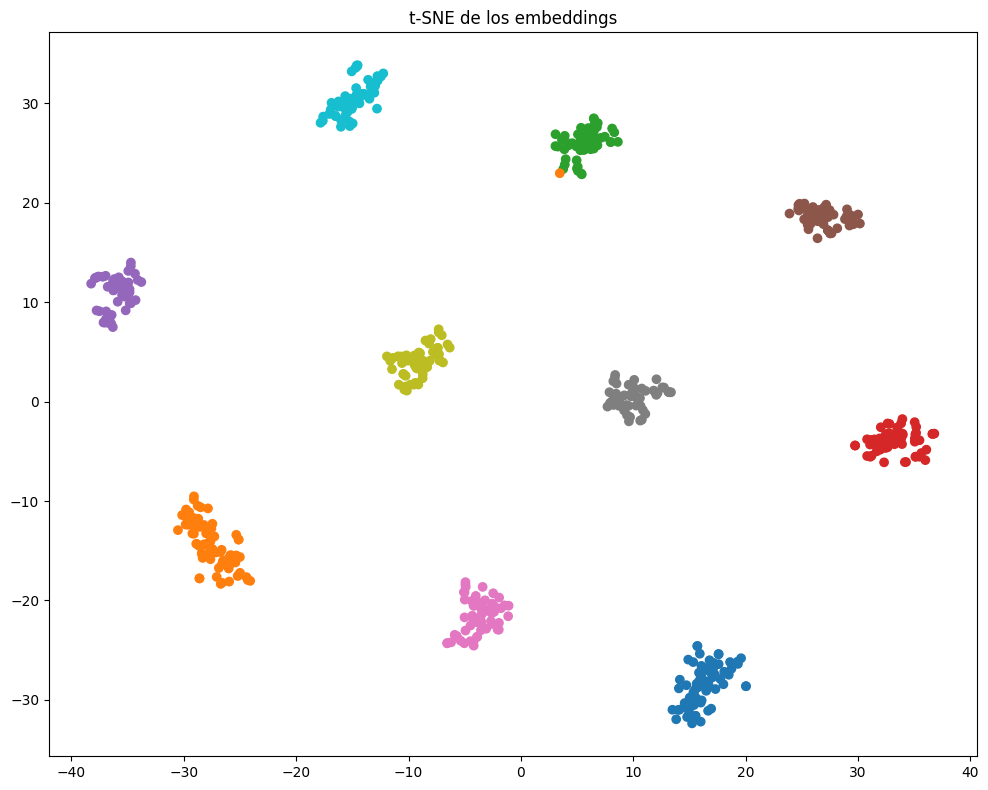

In [8]:
class CNN(nn.Module):
  def __init__(self, output_size=256):
    super(CNN, self).__init__()

    self.conv_block = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Dropout2d(0.1),
      nn.MaxPool2d((2, 1)),
      
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d((2, 2)),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d((2, 2)),

      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),

      nn.AdaptiveAvgPool2d((4, 4)),
    )

    self.embedding = nn.Sequential(
      nn.Flatten(),
      nn.Linear(256 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(1024, output_size),
    )

    self.scaler = GradScaler(device)

    self.training_ETA = 0.0
    self.total_epochs = 0
    self.current_epoch = 0
    self.is_model_trained = False
  
  def forward(self, x):
    if x.dim() > 4:
      x = x.squeeze(1)

    x = self.conv_block(x)
    x = self.embedding(x)

    return x

  def fit(self, train_loader, test_loader, epochs=50, learning_rate=0.001, patience=7):
    self.total_epochs = epochs
    training_epoch_duration = []

    loss_function = losses.TripletMarginLoss(margin=0.5, distance=distances.CosineSimilarity())
    miner = miners.TripletMarginMiner(margin=0.5, type_of_triplets="semi-hard", distance=distances.CosineSimilarity())

    optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
      self.train()
      epoch_loss = 0.0
      start_time = time.time()
      self.current_epoch = epoch

      for spectogram, label in train_loader:
        spectogram = spectogram.to(device, non_blocking=True)
        labels = label.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type=device):
          embeddings = self(spectogram)
          hard_triplets = miner(embeddings, labels)
          loss = loss_function(embeddings, labels, hard_triplets)
        
        self.scaler.scale(loss).backward()
        self.scaler.step(optimizer)
        self.scaler.update()

        epoch_loss += loss.item()
      
      # Calculate the average loss for the epoch
      avg_train_loss = epoch_loss / len(train_loader)

      # Validation
      val_loss = 0.0
      self.eval()
      with torch.no_grad():
        for spectogram, labels in test_loader:
          spectogram = spectogram.to(device, non_blocking=True)
          labels = labels.to(device, non_blocking=True)

          with autocast(device_type=device):
            embeddings = self(spectogram)
            hard_triplets = miner(embeddings, labels)
            loss = loss_function(embeddings, labels, hard_triplets)
          val_loss += loss.item()
      
      avg_val_loss = val_loss / len(test_loader)
      scheduler.step(avg_val_loss)

      # Early stopping
      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = self.state_dict()    
        patience_counter = 0
      else:
        patience_counter += 1
        if patience_counter >= patience:
          print(f"Early stopping at epoch {epoch}/{epochs}")
          break

      # Calculate the training ETA
      elapsed_time = time.time() - start_time
      training_epoch_duration.append(elapsed_time)
      self.training_ETA = (sum(training_epoch_duration) / (self.current_epoch + 1)) * (self.total_epochs - self.current_epoch)

      print(f"Epoch {self.current_epoch}/{self.total_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - ETA: {self.training_ETA:.2f}s")
    
    if best_model_state:
      self.load_state_dict(best_model_state)
      print(f"Best model loaded from epoch {self.current_epoch}/{self.total_epochs}")
    self.is_model_trained = True

  def predict(self, X):
    self.eval()

    X = torch.as_tensor(X, dtype=torch.float32)

    if isinstance(X, list):
        X = torch.stack(X)
    elif X.ndim == 2:
        X = X.unsqueeze(0)

    X = X.to(device)

    with torch.no_grad(), autocast(device_type=device):
        embeddings = self(X)

    embeddings = embeddings.cpu()

    return embeddings

  def save_trained_model(self):
    # Save the model
    torch.save(self.state_dict(), TRAINED_MODEL_FILE)

    print(f"Model saved to {TRAINED_MODEL_FILE}")
  
  def store_embeddings(self, train_loader, test_loader):
    # Check if the model is trained
    if not self.is_model_trained:
      raise Exception("Model is not trained. Please train the model before storing embeddings.")

    # Store the embeddings
    train_embeddings = []
    train_labels = []
    test_embeddings = []
    test_labels = []

    # Store the train embeddings
    for spectogram, label in train_loader:
      spectogram = spectogram.to(device, non_blocking=True)
      labels = label.to(device, non_blocking=True)

      with torch.no_grad(), autocast(device_type=device):
        embeddings = self.predict(spectogram)
      
      train_embeddings.append(embeddings.cpu())
      train_labels.append(labels.cpu())
    
    # Store the test embeddings 
    for spectogram, label in test_loader:
      spectogram = spectogram.to(device, non_blocking=True)
      labels = label.to(device, non_blocking=True)

      with torch.no_grad(), autocast(device_type=device):
        embeddings = self.predict(spectogram)
      
      test_embeddings.append(embeddings.cpu())
      test_labels.append(labels.cpu())

    # Concatenate the embeddings and labels
    train_embeddings = torch.cat(train_embeddings)
    train_labels = torch.cat(train_labels)
    test_embeddings = torch.cat(test_embeddings)
    test_labels = torch.cat(test_labels)

    embeddings = torch.cat([train_embeddings, test_embeddings])
    labels = torch.cat([train_labels, test_labels])

    print("Shape:", embeddings.shape)
    print("Mean por dimensión:", embeddings.mean(axis=0)[:5])
    print("Std por dimensión:", embeddings.std(axis=0)[:5])
    print("Varianza total:", embeddings.var())

    emb_np = embeddings.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    # Calcula el silhouette_score para train y test por separado
    train_score = silhouette_score(train_embeddings.numpy(), train_labels.numpy())
    test_score = silhouette_score(test_embeddings.numpy(), test_labels.numpy())
    print(f"Train Silhouette: {train_score:.4f}, Test Silhouette: {test_score:.4f}")

    np.savez_compressed(EMBEDDINGS_FILE, embeddings=emb_np, labels=labels_np)

    # Plot
    tsne = TSNE( n_components=2, perplexity=30, learning_rate='auto', init='random', max_iter=1000, random_state=42)

    test_embeddings_scaled = normalize(test_embeddings, norm='l2')
    test_embeddings_2d = tsne.fit_transform(test_embeddings_scaled)

    plt.figure(figsize=(10, 8))
    plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], c=test_labels, cmap='tab10')
    plt.title("t-SNE de los embeddings")
    plt.tight_layout()

  def load_trained_model(self):
    # Load the model
    map_location = torch.device(device)
    self.load_state_dict(torch.load(TRAINED_MODEL_FILE, map_location=map_location))
    self.eval()
    self.is_model_trained = True

def initialize_model():
  model = CNN().to(device)

  if torch.__version__ >= '2.0':
    model = torch.compile(model)

  return model

def train_model(model):
  train_ds, test_ds = get_spectograms()

  # Create DataLoaders for train and test sets
  train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS, pin_memory=True)
  test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS, pin_memory=True)

  # Check if the model is already trained
  if (os.path.exists(TRAINED_MODEL_FILE)):
    print(f"Model already trained. Loading model...")
    model.load_trained_model()
  else:
    print(f"Model not trained. Training model with {device}...")
    model.fit(train_loader=train_loader, test_loader=test_loader, epochs=50, learning_rate=0.001)
    model.save_trained_model()
    print(f"Model trained and saved.")

  # Check if the embeddings are already stored
  if (os.path.exists(EMBEDDINGS_FILE)):
    print(f"Embeddings already stored")
  else:
    print(f"Embeddings not stored. Storing embeddings...")

    model.store_embeddings(train_loader=train_loader, test_loader=test_loader)
    
  print(f"Embeddings stored.")

model = initialize_model()
train_model(model)

# Predict

Accuracy: 1.00 (100/100)


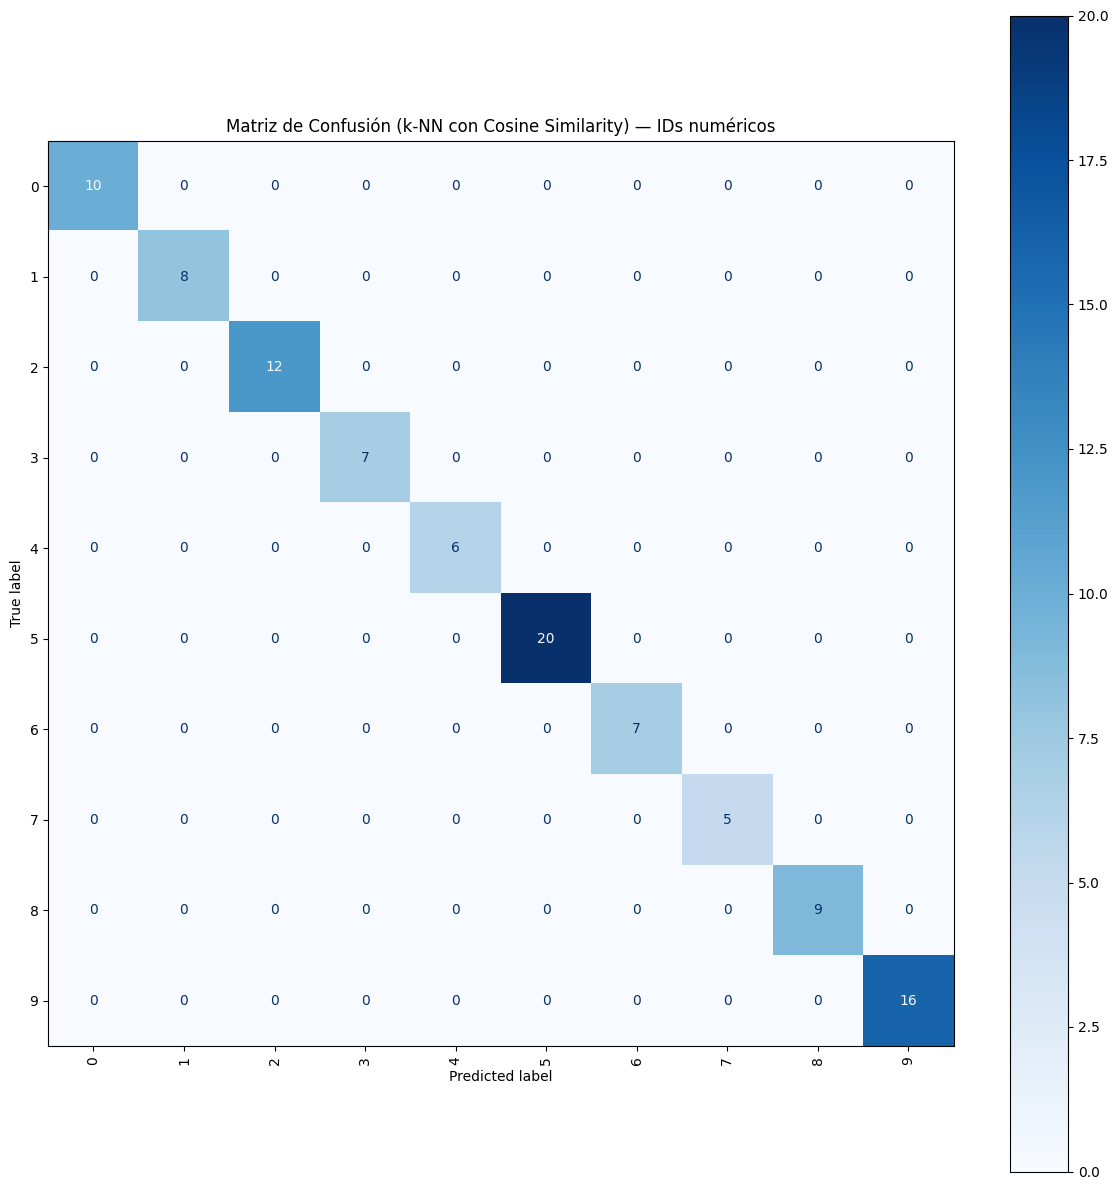

In [9]:
data = np.load(EMBEDDINGS_FILE)
emb_train = data['embeddings']
labels_train = data['labels']

# Initialize k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(emb_train, labels_train)

songs = os.listdir(SONGS_DIR) 
corrects = 0
y_true, y_pred = [], []
missing  = 0

for _ in range(NUM_TESTS):
  song = np.random.choice(songs)
  song_id = int(os.path.splitext(song)[0])
  song_path = os.path.join(SONGS_DIR, song)

  waveform, sr = get_waveform_n_sr_from_file(song_path)

  total_secs = waveform.shape[2] // sr
  start_sec = np.random.randint(0, max(1, total_secs - SEGMENT_DURATION) + 1)
  start = start_sec * sr
  segment = waveform[:, :, start:start + SEGMENT_DURATION * sr]

  mel_spec = get_spectogram(segment)

  # Normalize using the global mean & st
  mel_spec = (mel_spec - global_mean) / global_std

  emb = model.predict(mel_spec)

  pred_id = knn.predict(emb)[0]

  y_true.append(song_id)
  y_pred.append(pred_id)
  if pred_id == song_id:
    corrects += 1

executed = len(y_true)
accuracy = corrects / executed
print(f"Accuracy: {accuracy:.2f} ({corrects}/{executed})")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
plt.title("Matriz de Confusión (k-NN con Cosine Similarity) — IDs numéricos")
plt.tight_layout()
plt.show()